# The examples of section 3 
## You just need to run the entire notebook.

## Importing libraries : 

In [1]:
import os
import csv
from sklearn.metrics import auc, roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from FIF import *

# Direction importance:

### Constructing Dyadic dictionary by hand:

In [2]:
def dyadic(J_max=7, m=100):
    a =0
    t = np.linspace(0,1,m)
    D = np.zeros((np.sum(np.power(2,np.arange(J_max))),m))
    for J in range(J_max):
        b = np.power(2,J)
        for k in range(b):
            for l in range(m):
                x = b * t[l] - k
                D[a,l] = 1 * (0 <= x < 1)
            a += 1
    return D

### Importing dataset:

In [3]:
os.chdir('../Datasets')
X_trainz = pd.read_csv('CinECGTorso_Train.csv', header = None)
X_train = np.array(X_trainz, dtype= float )[:,1:]
y_train = np.array(X_trainz, dtype= int )[:,0]
time = np.linspace(0,1,X_train.shape[1])
os.chdir('../Section_3')

### Plotting the dataset:

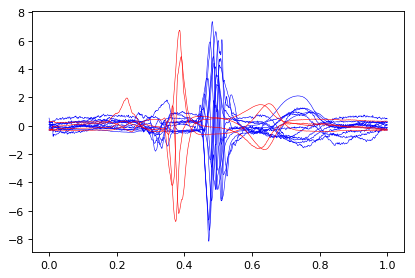

In [4]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(y_train)):
    if (y_train[i] == 1):
        plt.plot(time, X_train[i,:],c="b",linewidth = 0.5)
    elif(y_train[i] == -1):
        plt.plot(time, X_train[i,:],c="r",linewidth = 0.5)


### Applying FIF:

In [5]:
np.random.seed(42)
D1 = dyadic(6, m=X_train.shape[1])
F1 = FIForest(X_train, ntrees=100, time = time, subsample_size= X_train.shape[0], 
            D= D1, innerproduct= "auto", alpha = 1, criterion="sample")
b = F1.importance_feature()

### Plotting the histogram of feature importance:

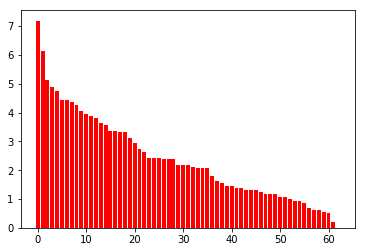

In [6]:
plt.figure(figsize=(6,4))
plt.bar( np.arange(len(b)), height= np.flip(np.sort(b)), color='r' )
#plt.savefig('feature_importance.pdf')
plt.show()

### Plotting the two best directions:

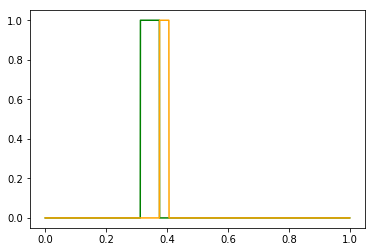

In [7]:
plt.figure(figsize=(6,4))
plt.plot(time, D1[np.flip(np.argsort(b))[0]], c='g')
plt.plot(time, D1[np.flip(np.argsort(b))[1]], c='orange')
plt.show()

# The example with different kind of anomaly:

### Constructing the dataset :

In [8]:
np.random.seed(42)
m =100
n =100
tps = np.linspace(0,1,m)
v = np.linspace(1,1.4,n)
X = np.zeros((n,m))
for i in range(n):
    X[i] = 30 * ((1-tps) ** v[i]) * tps ** v[i]

    
Z1 = np.zeros((m))
for j in range(m):
    if (tps[j]<0.2 or tps[j]>0.8):
        Z1[j] = 30 * ((1-tps[j]) ** 1.2) * tps[j] ** 1.2 
    else:
        Z1[j] = 30 * ((1-tps[j]) ** 1.2) * tps[j] ** 1.2 + np.random.normal(0,0.3,1)
Z1[0] = 0
Z1[m-1] = 0


Z2 = 30 * ((1-tps) ** 1.6) * tps ** 1.6


Z3 = np.zeros((m))
for j in range(m):
    Z3[j] = 30 * ((1-tps[j]) ** 1.2) * tps[j] ** 1.2 + np.sin(2*np.pi*tps[j])
    
Z4 = np.zeros((m))
for j in range(m):
    Z4[j] = 30 * ((1-tps[j]) ** 1.2) * tps[j] ** 1.2
    
for j in range(70,71):
    Z4[j] += 2
    
Z5 = np.zeros((m))
for j in range(m):
    Z5[j] = 30 * ((1-tps[j]) ** 1.2) * tps[j] ** 1.2 + 0.5*np.sin(10*np.pi*tps[j])
    
X = np.concatenate((X,Z1.reshape(1,-1),Z2.reshape(1,-1),  
                     Z3.reshape(1,-1), Z4.reshape(1,-1), Z5.reshape(1,-1)), axis = 0)



### Applying FIF :

In [9]:
# Sobolev scalar product and Gaussian wavelets dictionary :
np.random.seed(42)
F3  = FIForest(X, D="gaussian_wavelets", time=tps, innerproduct="auto", alpha=0.5)
S3  = F3.compute_paths()

### Plotting the dataset :

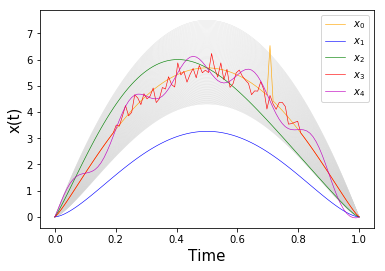

In [10]:
plt.figure(figsize=(6,4))
for i in range(100):
    plt.plot(tps, X[i], c='Lightgray', linewidth=0.3)
    
plt.plot(tps,Z4,c='orange', label='$x_0$', linewidth=0.6)

plt.plot(tps,Z2,c='b', label='$x_1$', linewidth=0.6)
plt.plot(tps,Z3,c='g', label='$x_2$', linewidth=0.6)
plt.plot(tps,Z1,c='r', label='$x_3$', linewidth=0.6)
plt.plot(tps,Z5,c='m', label='$x_4$', linewidth=0.6)

plt.legend()
plt.ylabel('x(t)',size='15')
plt.xlabel('Time',size=15)
#plt.savefig('anomaly_example.pdf')
plt.show()

### Plotting the sorted dataset :

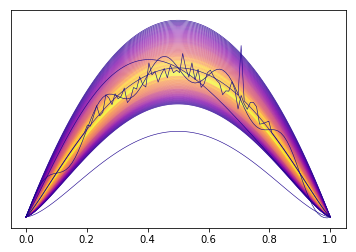

In [11]:
colors = [ matplotlib.cm.plasma_r(x)
            for x in np.linspace(0, 1, len(S3)) ]
plt.figure(figsize=(6,4))
for j in range(0,len(colors)):
    plt.plot(tps, X[np.argsort(S3)[j],:], '-', c=colors[j], zorder=1, linewidth = 0.6)
    #plt.xlabel('Time')
    #plt.ylabel('x(t)')
    #plt.title('Alpha = 1', size=20)

  
    
sm = plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis_r,
 
                                   norm=plt.Normalize(vmin=0, vmax=1))
plt.yticks([]) 
sm._A = []
#plt.savefig('anomaly_example_rank.pdf')
plt.show()

### Plotting the sorted score of the dataset :

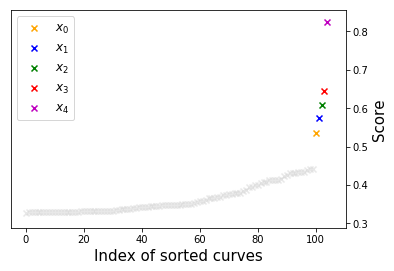

In [12]:
fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
for i in range(len(S3)-5):
    ax.scatter(np.arange(len(S3))[i],np.sort(S3)[i], color='Lightgray', marker='x',alpha=0.5)

ax.scatter(100, np.sort(S3)[100], color='orange', marker='x', label='$x_0$')
ax.scatter(101, np.sort(S3)[101], c='b', marker='x', label='$x_1$')
ax.scatter(102, np.sort(S3)[102], c='g', marker='x',  label='$x_2$')
ax.scatter(103, np.sort(S3)[103], c='r', marker='x', label='$x_3$')
ax.scatter(104, np.sort(S3)[104], c='m', marker='x', label='$x_4$')

ax.set_xlabel('Index of sorted curves',size=15)
ax.yaxis.tick_right()

ax.yaxis.set_label_position("right")
ax.set_ylabel('Score',size=15)
ax.legend(fontsize='large')
#plt.savefig("anomaly_example_score.pdf")
plt.show()